# Bayesian Data Analysis - Project
___

__Note!__ The submitted notebooks need to illustrate the knowledge of the Bayesian workflow

__RUBRIC:__ 
* The introduction is inviting, presents an overview of the notebook. Information is relevant and presented in a logical order.
* The conclusion is clear
* The notebook presents a clear cohesive data analysis story, which is enjoyable to read
* Accuracy of use of statistical terms: Statistical terms are used accurately and with clarity 
* Description of the data, and the analysis problem
* Description of the model
* Description of the prior choices: Priors are listed and justiﬁed
* Is Stan code included?
* Is code for how Stan model is run included?
*  Is required convergence diagnostics (Rhat, divergences, neff) included?: Required onvergence diagnostic results shown and maning of the results is discussed
* Is there posterior predictive checking?
*  Is there a discussion of problems and potential improvements ?
___


## 1 Introduction

**Goal**: analyze the distribution of outcomes in a badminton tournament.

**Approach**: apply Bayesian data analysis on historical data of badminton tournaments. The estimand of interest is the probability of winning with a certain ranking spread.

**Implementation**:
* Start with some naive assumption of the estimand, in order to choose the model later
* Collect and preprocess data
* Decide on prior choices and models
* Do stan analysis on each models
* Model comparision (using PSIS-LOO)
* Do posterior predictive comparision between models
* Conclusion, possible improvements




## 2 Analysis problem

### 2.1 Discretizing the problem
In one tournament, there are 8 seed players and some unranked players. To discretize the ranking spread, we chose 12th as the rank for all unranked players. The spread is calculated as follows:

**Spread (from 1st player perspective) = Rank(2nd player) - Rank(1st player)**

E.g.

* Spread(from 1st rank player to 8th rank player) = 8 - 1 = 7
* Spread(from 2nd rank player to unrank player) = 12 - 2 = 10
* Spread(from unrank player to 3rd rank player) = 3 - 12 = -9

The discrete space for ranking spread is then **[-11,-10,-9,...,9,10,11]**

A match (which has at most 3 games) has 6 possible outcomes:
1. Lose Lose     -> Lose
2. Lose Win Lose -> Lose
3. Win Lose Lose -> Lose
4. Lose Win Win  -> Win
5. Win Lose Win  -> Win
6. Win Win       -> Win 

To discretize this parameter, we map the outcome of a match to **[1,2,3,4,5,6]** in terms of win degree (i.e. win degree 1 is the worst, and win degree 6 is the best)


For the match below, ranking spread is 11, win degree is 4

<img src="match_beautified.png" alt="match" style="width: 600px; margin-left: 0"/>

### 2.2 Modeling the problem

Unless stated otherwise, all information in the data are from 1st player perspective  
An observation of a match includes 2 pieces of information:
* ranking spread
* win degree

To formulate the observations as a one dimensional space collection, we need to reduce the matrix 23x6 (23 different spreads, 6 different win degrees) of all possible raw observations. The intuition of the reduction is as follows:
* With the same ranking spread, higher win degree correlates to higher value (see arrow A in image below)
* With the same win degree, lower ranking spread correlates to higher value (see arrow B in image below)
* Step between value is 1

With the given constraint, we will have **28 possible values of observation from [1,28]**. The mapping is as follow (columns are win degrees and rows are ranking spreads)

<img src="mapping4.jpg" alt="mapping" style="width: 400px; margin-left: 0"/>

### 2.3 Analysing the problem

The analysis problem is the distribution of observations and how they differ between different tournaments. Furthermore, we will also try and the analyze the affect of different models and priors choice.


## 3 Dataset and data model

The dataset is collected from Badminton World Federation (BWF) tournament database using Scrapy crawler. After collecting, the data is preprocessed as stated in the previous section. In the end, the format of data is similar to the factory data assignments. A peek of the data:

In [4]:
show_first_rows_of_data()

,Tournament 1,Tournament 2,Tournament 3,Tournament 4,Tournament 5
Match 1,6.0,17.0,16.0,6.0,1.0
Match 2,15.0,15.0,17.0,13.0,17.0
Match 3,16.0,7.0,4.0,17.0,5.0
Match 4,15.0,13.0,17.0,17.0,13.0
Match 5,19.0,20.0,20.0,15.0,17.0


In [8]:
show_summary_of_data()

,Tournament 1,Tournament 2,Tournament 3,Tournament 4,Tournament 5
count,67.000000,67.000000,67.000000,67.000000,67.000000
mean,13.776119,14.388060,13.746269,14.880597,14.164179
std,5.746727,5.635266,5.329572,5.878885,5.703792
min,4.000000,3.000000,4.000000,3.000000,1.000000
25%,9.000000,10.000000,8.000000,10.000000,10.000000
50%,15.000000,15.000000,15.000000,16.000000,16.000000
75%,17.000000,18.000000,17.000000,17.000000,17.000000
max,25.000000,27.000000,26.000000,27.000000,27.000000


## 4 Prior choices

We decided to use two different priors: 
* **Inverse gamma** is chosen on variance because it is the conjugate prior to normal likelihood and it has a closed form solution for the outcome of the posterior
* **Uniform** is chosen as weak prior to observe how sensitive is outcome in regards the prior and the data input

## 5 Model

In normal distribution where $\mu$ is known and $\sigma^2$ is unknown, the marginal posterior distribution $p(\sigma^2|y)$ can be computed as described below. The posterior distribution is computed using two different priors, whereas the first is an uniformative (uniform) and the second an informative (inverse gamma) prior.

__Priors:__

Uniform prior

\begin{equation*}
p(\sigma^2) \propto Uniform(0, \infty)
\end{equation*}

Inverse gamma prior

\begin{equation*}  
p(\sigma^2) \propto (\sigma^2)^{-(a+1)}e^{-\beta/\sigma^2} \propto Inv-Gamma(\alpha, \beta) \\
\end{equation*}

where $\alpha$ and $\beta$ are the shape and scale parameters. __The values of the parameters ??__

__Likelihood:__
\begin{equation*}
p(y|\mu,\sigma^2) \propto \prod_{i=1}^{N} p(y_i | \mu, \sigma^2) \propto N(y | \mu, \sigma^2) 
\end{equation*}

where $\mu$ is known.

__Posterior:__

\begin{equation*}
p(\sigma^2 | y) \propto p(\sigma^2)p(y|\mu, \sigma^2)
\end{equation*}

Since one of the objective is to predict the distribution of a new tournament, we will use pooled and hierarchical model. The separate model is excluded because it handles the tournaments uniquely  without having any common parameters which could be used to predict the new tournament.

In the pooled model the mean and the variance is computed from the combined data of all the tournaments and there is no distinction between different tournaments. This means that also the new tournament will have similar distibution as the predictive distribution of the tournaments.  

In the hierarchical model each tournament is handled separately having own mean and common standard deviation. Furthermore, all the means are controlled by common hyperparameters ($\mu_0$ and $\sigma^2_0$) which means that the means are drawn from the common distribution described by these hyperparameters. The result of the new tournament can be predicted using the common hyperparameters: first draw the mean from the common distribution and use it to sample the predictive distribution. 

Then based on the prior choices, we have 4 different models:
* pooled with uniform prior
* pooled with inverse gamma prior for variance
* hierarchical with uniform prior
* hierarchical with inverse gamma prior for variance

## 6 Stan analysis of the models

For each model, we will show the Stan model and convergence diagnostic.

The Stan model is fitted using Stan's default parameters (4 chains, 1000 warmup iterations, 1000 sampling iteration, ending up to 4000 samples and 10 as maximum tree depth). In addition, to avoid false positive conclusion about divergences, the *adapt_delta* value is set to 0.9. This means that the fitting uses larger target acceptance probability and therefore all the divergences can be seen. If the resulting value is still 0 after this, we can verify that there are no divergences. If not, the divergences could be furter analyzed by increasing *adapt_delta*.

Besides divergences, the converge diagnostic includes a short discussion about $\hat R$ and n_eff. Generally, if the $\hat R$ values of the parameters are close to 1 and below 1.1, the fit has been good. The low $\hat R$ values combined with high effective sample size (n_eff) per transition informs that the Markov chains were mixed well. Note that discussion about depth tree and energy Bayesian fraction of missing information (E-BFMI) is left out because their results were same for all the models (depth tree 0 and E-BFMI did not give any information).

### 6.1 Pooled model with uniform prior

#### Stan model

The stan code of the model:
```
data {
  int<lower=0> N;		// Number of observations
  vector[N] y;           // N observations for J tournaments
}
parameters {
  real mu;              // Common mean
  real<lower=0> sigma;  // Common std
}
model {
  y ~ normal(mu, sigma);// Model for fitting data using tournament specific mu and common std
}
generated quantities {
  vector[N] log_lik;
  real ypred;
  
  ypred = normal_rng(mu, sigma);	              //Prediction of tournament
  for (n in 1:N)
    log_lik[n] = normal_lpdf(y[n] | mu, sigma);   //Log-likelihood
}
```
#### Convergence diagnostic
After compiling the model and fitting the combined data of the tournaments, the diagnostic of the fit was examined:

| Diagnostic | Result   |
|---|---|
| All $\hat R$ values close to 1 | OK |
| Low $\hat R$ values combined with high effective sample size (n_eff) | OK |
| Divergences is 0 | OK |

All the results for pooled uniform prior model fitting are good. The full fit can be found in the _Attachment 1_ and a shorter summary is shown below.

In [9]:
# Fit pooled uniform model
pool_uni_df, pool_uni_fit = compute_model(r'stan_code/pool_uniform_prior.stan', pooled_data_model)
# Print summary of the fit
print_compact_fit(pool_uni_df)

Using cached StanModel


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu,14.1935,0.00600038,0.314179,13.5613,13.9842,14.2001,14.409,14.8204,2741.55,1.00109
sigma,5.66282,0.00436431,0.224035,5.24378,5.50642,5.65253,5.80839,6.12739,2635.11,1.00018
log_lik[1],-3.70522,0.00177157,0.091105,-3.89356,-3.76527,-3.70164,-3.64204,-3.53086,2644.65,1.00078
log_lik[2],-2.66381,0.000786235,0.0394576,-2.7439,-2.68967,-2.66273,-2.63632,-2.58826,2518.59,1.00023
log_lik[3],-2.70475,0.000795354,0.0395853,-2.78604,-2.73049,-2.70434,-2.67761,-2.62968,2477.12,1.00032
...,...,...,...,...,...,...,...,...,...,...
log_lik[333],-2.70475,0.000795354,0.0395853,-2.78604,-2.73049,-2.70434,-2.67761,-2.62968,2477.12,1.00032
log_lik[334],-2.81336,0.000764005,0.0414903,-2.89455,-2.84142,-2.81289,-2.78428,-2.73293,2949.17,1.00091
log_lik[335],-3.46419,0.00142921,0.0745643,-3.61728,-3.51306,-3.46244,-3.41316,-3.32091,2721.9,1.00092
ypred,14.2868,0.0931885,5.70274,3.42566,10.3648,14.2842,18.1957,25.5974,3744.92,0.999995


In [10]:
print_compact_fit_checking(pool_uni_fit, pool_uni_df)

Maximum value of the Rhat: 
1.0012218111524749

Divergences:
0.0 of 4000 iterations ended with a divergence (0.0%)



### 6.2 Pooled model with inverse gamma prior

#### Stan model
The stan code of the model:
```
data {
  int<lower=0> N;		 // Number of observations
  vector[N] y;            // N observations for J tournaments
  real<lower=0.1> alpha;  //Shape
  real<lower=0.1> beta;  //Scale
}
parameters {
  real mu;               // Common mean
  real<lower=0> sigmaSq; // Common var
}
transformed parameters {
  real<lower=0> sigma;
  sigma <- sqrt(sigmaSq);
}
model {
  sigmaSq ~ inv_gamma(alpha,beta);  // Prior
  y ~ normal(mu, sigma);            // Fitting of the model
}
generated quantities {
  vector[N] log_lik;
  real ypred;
  
  ypred = normal_rng(mu, sigma);	// Prediction of tournament
  for (n in 1:N)
    log_lik[n] = normal_lpdf(y[n] | mu, sigma); //Log-likelihood
}

```

#### Convergence diagnostic
The same procedure is followed here (as in the previous section) and similar results were obtained:

| Diagnostic | Result   |
|---|---|
| All $\hat R$ values close to 1 | OK |
| Low $\hat R$ values combined with high effective sample size (n_eff) | OK |
| Divergences is 0 | OK |

All the results for pooled inverse gamma prior model fitting are good. The full fit can be found in the _Attachment 2_ and a shorter summary is shown below.

In [11]:
# Fit pooled inverse gamma model
pool_inv_df, pool_inv_fit = compute_model(r'stan_code/pool_inverse_gamma_prior.stan', pooled_data_model)
# Print summary of the fit
print_compact_fit(pool_inv_df)

Using cached StanModel


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu,14.1912,0.00657132,0.311324,13.5848,13.9808,14.1944,14.3957,14.8102,2244.51,1.00237
sigmaSq,31.819,0.0466149,2.42705,27.4953,30.0994,31.688,33.3725,36.8217,2710.87,1.00037
sigma,5.63676,0.00410084,0.21424,5.2436,5.48629,5.62921,5.77689,6.06809,2729.33,1.00037
log_lik[1],-3.70983,0.00186521,0.0933245,-3.89964,-3.77044,-3.7058,-3.64535,-3.53664,2503.44,1.00087
log_lik[2],-2.65936,0.000733353,0.0384743,-2.73647,-2.68499,-2.65882,-2.63316,-2.58596,2752.42,0.999909
...,...,...,...,...,...,...,...,...,...,...
log_lik[333],-2.70068,0.000756813,0.039352,-2.78049,-2.72698,-2.70021,-2.67379,-2.62523,2703.69,0.999668
log_lik[334],-2.81015,0.000862704,0.0394174,-2.88917,-2.83559,-2.80985,-2.78294,-2.7354,2087.62,1.00321
log_lik[335],-3.46668,0.00155329,0.0761101,-3.62117,-3.51465,-3.46372,-3.41446,-3.3255,2400.92,1.00139
ypred,14.2633,0.0890259,5.61407,3.23815,10.4847,14.328,18.0029,25.224,3976.7,0.999202


In [12]:
print_compact_fit_checking(pool_inv_fit, pool_inv_df)

Maximum value of the Rhat: 
1.00330613987631

Divergences:
0.0 of 4000 iterations ended with a divergence (0.0%)



### 6.3 Hierarchical model with uniform prior

### 6.3.1  Unsuccessful fitting

#### Stan model 
The stan code of the model:
```
data {
  int<lower=0> N;  // Number of observations
  int<lower=0> J;  // Number of tournaments
  matrix[N,J] y;  // N observations for J tournaments
}
parameters {
  real mu0;             // Common mu for each J tournament's mu
  real<lower=0> sigma0; // Common std for each J tournament's mu
  real<lower=0> sigma; // Common std between tournaments
  real mu_tilde[J];    // Tournament specific mu
}
model {
  for (j in 1:J)
    mu[j] ~ normal(mu0, sigma0);	   // Model for computing tournament specific mu from common mu0 and sigma0
  for (j in 1:J)
    y[:,j] ~ normal(mu[j], sigma);	// Model for fitting data using tournament specific mu and common std
}
generated quantities {
  matrix[N,J] log_lik;    
  real ypred[J];
  real mu_new;
  real ypred_new;
  
  for (j in 1:J)
     ypred[j] = normal_rng(mu[j], sigma);	// Predictive distibutions of all the tournaments
  mu_new = normal_rng(mu0, sigma0);	      // Next posterior distribution from commonly learned mu0 and sigma0
  ypred_new = normal_rng(mu_new, sigma);	// Next predictive distibutions of new tournament
  
  for (j in 1:J)
     for (n in 1:N)
        log_lik[n,j] = normal_lpdf(y[n,j] | mu[j], sigma); //Log-likelihood
}
```

#### Convergence diagnostic attempt 1
The same procedure is followed here (as in the previous section) with minor change. The data set used for fitting is a matrix where columns are the tournaments and rows are the matches in the tournaments. The diagnostic results are:

| Diagnostic | Result   |
|--|--|
| All $\hat R$ values close to 1 | __NO__ <br> *lp__* is 1.4 |
| Low $\hat R$ values combined with high effective sample size (n_eff) | __NO__ |
| Divergences is 0 | __NO__ <br> 8% of the target posterior was not explored|


Because none of the conditions were fulfilled, in the next step we will try to improve the results by reducing the accuracy of the simulations by increasing the value of the *adapt_delta* parameter.

The results of the attempt 1 can be seen below.

In [13]:
# Fit hierarchical uniform model
hier_uni_df, hier_uni_fit = compute_model(r'stan_code/hier_uniform_prior.stan', hierarchical_data_model)
# Print the summary of the fit
print_compact_fit(hier_uni_df)

Using cached StanModel


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu0,14.2329,0.0210308,0.446391,13.3487,13.9735,14.2752,14.4995,15.0644,450.525,1.02431
sigma0,0.535161,0.0535548,0.666496,0.034287,0.175319,0.377991,0.695489,1.96664,154.881,1.03681
mu[1],14.114,0.0345285,0.487501,13.0342,13.8039,14.1652,14.448,14.9575,199.341,1.0351
mu[2],14.297,0.016115,0.452935,13.401,14.0037,14.3409,14.5523,15.2336,789.965,1.0124
mu[3],14.1032,0.0403407,0.499981,12.9984,13.7959,14.1444,14.4328,14.9681,153.61,1.04148
...,...,...,...,...,...,...,...,...,...,...
ypred[4],14.5321,0.091044,5.72121,3.43923,10.6284,14.5042,18.3391,25.8417,3948.87,0.999994
ypred[5],14.2075,0.0905965,5.76997,2.85561,10.45,14.2165,18.162,25.5799,4056.24,1.00051
mu_new,14.2334,0.0218519,1.01022,12.4586,13.8867,14.303,14.5749,15.8835,2137.22,1.00511
ypred_new,14.4269,0.0903533,5.75049,3.12519,10.5392,14.4873,18.2871,25.5047,4050.63,0.999947


In [14]:
print_compact_fit_checking(hier_uni_fit, hier_uni_df)

Maximum value of the Rhat: 
1.4271803879965732

Divergences:
334.0 of 4000 iterations ended with a divergence (8.35%)
Try running with larger adapt_delta to remove the divergences



#### Convergence diagnostic attempt 2

After changing the accuracy of the simulations from 0.9 to 0.93, the data is re-fit and following results were gained:

| Diagnostic | Result   |
|--|--|
| All $\hat R$ values close to 1 | OK |
| Low $\hat R$ values combined with high effective sample size (n_eff) | OK |
| Divergences is 0 | __NO__ <br> still 2% of the target posterior was not explored|

With these results we can verify that the hierarchical uniform prior model fitting is almost successful. Although, this is not the desired result and therefore, in the next step the further improvement is discussed. 

The results of the attempt 2 is shown below.

In [15]:
# Fit hierarchical uniform model
hier_uni_df, hier_uni_fit = compute_model(r'stan_code/hier_uniform_prior.stan', 
                                          hierarchical_data_model, adapt_delta=0.93)
# Print the summary of the fit
print_compact_fit(hier_uni_df)

Using cached StanModel


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu0,14.1644,0.0123891,0.448593,13.2637,13.9137,14.1605,14.417,15.0649,1311.07,1.00379
sigma0,0.577572,0.0241451,0.555903,0.0494482,0.206924,0.425261,0.754488,2.11755,530.077,1.0035
mu[1],14.0469,0.0123664,0.479679,13.0261,13.7479,14.0788,14.3508,14.9718,1504.58,1.00265
mu[2],14.2379,0.0123815,0.479718,13.3171,13.9355,14.2193,14.5283,15.2269,1501.15,1.00178
mu[3],14.0249,0.0116276,0.474814,12.9799,13.7521,14.05,14.3176,14.9232,1667.51,1.00145
...,...,...,...,...,...,...,...,...,...,...
ypred[4],14.4256,0.090406,5.67435,3.12951,10.5871,14.4805,18.3036,25.3037,3939.47,0.999826
ypred[5],14.2654,0.0902164,5.56599,3.36346,10.5995,14.3043,18.0873,25.173,3806.39,1.00009
mu_new,14.1752,0.0190338,0.98601,12.29,13.7885,14.1633,14.5453,16.1217,2683.57,1.00057
ypred_new,14.1611,0.0888624,5.71322,3.04275,10.2978,14.0084,18.0118,25.32,4133.58,0.999925


In [16]:
print_compact_fit_checking(hier_uni_fit, hier_uni_df)

Maximum value of the Rhat: 
1.0137355255526934

Divergences:
126.0 of 4000 iterations ended with a divergence (3.15%)
Try running with larger adapt_delta to remove the divergences



### 6.3.2 Successful fitting

In this section, we will modify the Stan code and use exactly the same approach as described in pystan's workflow (http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html, A Successful Fit). Because the fit of the centered parametrization is not successful, we should change the Stan code using non-centered parametrization.

__Centered__ parametrization of parameter _mu_
```
parameters {
  ...
  real mu[J]; // Tournament specific mu
  ...
}
model {
  for (j in 1:J) // Model for computing tournament specific mu from common mu0 and sigma0
    mu[j] ~ normal(mu0, sigma0);
  ...
}
```

is converted __to non-centered__ parametrization 
```
parameters {
  ...
  real mu_tilde[J];
}
transformed parameters {
  real mu[J];// Tournament specific mu
  for (j in 1:J)
    mu[j] = mu0 + sigma0 * mu_tilde[j];
}
model {
  for (j in 1:J) // Model for computing tournament specific mu from common mu0 and sigma0
    mu_tilde[j] ~ normal(0, 1); // Implies mu[j] ~ normal(mu0,sigma0)
  ...
}
```
The full updated Stan code is shown in the next section.

#### Stan model 
The stan code of the model:
```
data {
  int<lower=0> N;  // Number of observations
  int<lower=0> J;  // Number of tournaments
  matrix[N,J] y;  // N observations for J tournaments
}
parameters {
  real mu0;             // Common mu for each J tournament's mu
  real<lower=0> sigma0; // Common std for each J tournament's mu
  real<lower=0> sigma; // Common std between tournaments
    real mu_tilde[J];
}
transformed parameters {
  real mu[J];          // Tournament specific mu
  for (j in 1:J)
    mu[j] = mu0 + sigma0 * mu_tilde[j];
}
model {
  for (j in 1:J)                   // Model for computing tournament specific mu from common mu0 and sigma0
    mu_tilde[j] ~ normal(0, 1);    // Implies mu[j] ~ normal(mu0,sigma0)
  for (j in 1:J)
    y[:,j] ~ normal(mu[j], sigma); // Model for fitting data using machine specific mu and common std
}
generated quantities {
  matrix[N,J] log_lik;    
  real ypred[J];
  real mu_new;
  real ypred_new;
  
  for (j in 1:J)
     ypred[j] = normal_rng(mu[j], sigma);	// Predictive distibutions of all the tournaments
  mu_new = normal_rng(mu0, sigma0);	      // Next posterior distribution from commonly learned mu0 and sigma0
  ypred_new = normal_rng(mu_new, sigma);	// Next predictive distibutions of new tournament
  
  for (j in 1:J)
     for (n in 1:N)
        log_lik[n,j] = normal_lpdf(y[n,j] | mu[j], sigma); //Log-likelihood
}
```

#### Convergence diagnostic attempt 3

The same procedure is followed (as in the previous section) and improved results were obtained:

| Diagnostic | Result   |
|--|--|
| All $\hat R$ values close to 1 | OK |
| Low $\hat R$ values combined with high effective sample size (n_eff) | OK |
| Divergences is 0 | GOOD ENOUGH <br> still 0.025% of the target posterior was not expolred <br> and increasing *adapt_delta* did not improve this result|

All of these verify that hierarchical uniform prior model fitting is successful enough. The full fit can be found in the _Attachment 3_ and a shorter summary is shown below.

In [17]:
# Fit hierarchical uniform model
hier_uni_df, hier_uni_fit = compute_model(r'stan_code/hier_uniform_prior_v2.stan', hierarchical_data_model)
# Print the summary of the fit
print_compact_fit(hier_uni_df)

Using cached StanModel


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu0,14.1961,0.0140927,0.458058,13.2531,13.9249,14.1917,14.464,15.1017,1056.46,1.00285
sigma0,0.550535,0.0179474,0.576781,0.0140076,0.18154,0.388406,0.717958,2.06309,1032.8,1.00309
sigma,5.66836,0.00367403,0.213634,5.26576,5.52314,5.66113,5.80597,6.10786,3381.09,0.999766
mu_tilde[1],-0.207582,0.0159433,0.883688,-1.97272,-0.795004,-0.21698,0.373531,1.49234,3072.15,0.999875
mu_tilde[2],0.10843,0.0155834,0.883542,-1.68338,-0.477808,0.101281,0.691408,1.87599,3214.61,1.00029
...,...,...,...,...,...,...,...,...,...,...
ypred[4],14.4115,0.0923052,5.77547,2.91519,10.6273,14.3439,18.2793,25.8232,3914.91,0.999828
ypred[5],14.1985,0.0890953,5.63667,3.05899,10.3145,14.244,18.0424,24.8852,4002.54,0.999548
mu_new,14.2178,0.0179631,0.940442,12.446,13.8592,14.2051,14.5741,16.0938,2740.97,0.999788
ypred_new,14.198,0.0913551,5.80221,2.83785,10.2555,14.1872,18.1655,25.4919,4033.87,0.999715


In [18]:
print_compact_fit_checking(hier_uni_fit, hier_uni_df)

Maximum value of the Rhat: 
1.0030853274280642

Divergences:
1.0 of 4000 iterations ended with a divergence (0.025%)
Try running with larger adapt_delta to remove the divergences



### 6.4 Hierarchical model with inverse gamma prior

#### Stan model

The stan code of the model (using non-centered parametrization):
```
data {
  int<lower=0> N; 			// Number of observations
  int<lower=0> J; 			// Number of tournaments
  matrix[N,J] y; 			// N measurements for J tournaments
}
parameters {
  real mu0;				// Common mu for each J tournaments's mu
  real<lower=0> sigma0;			// Common std for each J tournament's mu
  real<lower=0> sigma;			// Common std
  real mu_tilde[J];
}
transformed parameters {
  real mu[J];			// Tournament specific mu
  for (j in 1:J)
    mu[j] = mu0 + sigma0 * mu_tilde[j];
}
model {
  for (j in 1:J) // Model for computing tournament specific mu from common mu0 and sigma0
    mu_tilde[j] ~ normal(0, 1); // Implies mu[j] ~ normal(mu0,sigma0)
  for (j in 1:J)
    y[:,j] ~ normal(mu[j], sigma);	// Model for fitting data using tournament specific mu and common std
}
generated quantities {
  matrix[N,J] log_lik;    
  real ypred[J];
  real mu_new;
  real ypred_new;
  
  for (j in 1:J)
     ypred[j] = normal_rng(mu[j], sigma);	// Predictive distibutions of all the tournaments
  mu_new = normal_rng(mu0, sigma0);	// Next posterior distribution from commonly learned mu0 and sigma0
  ypred_new = normal_rng(mu_new, sigma);	// Next predictive distibutions of new tournament
  
  for (j in 1:J)
     for (n in 1:N)
        log_lik[n,j] = normal_lpdf(y[n,j] | mu[j], sigma); //Log-likelihood
}


```

#### Convergence diagnostic
The same procedure is followed (as in the previous section) and the diagnostic results are:


| Diagnostic | Result   |
|--|--|
| All $\hat R$ values close to 1 | OK |
| Low $\hat R$ values combined with high effective sample size (n_eff) | OK |
| Divergences is 0 | GOOD ENOUGH <br> still 0.025% of the target posterior was not expolred <br> and increasing *adapt_delta* did not improve this result|

All of these verify that hierarchical inverse gamma prior model fitting is successful enough. The full fit can be found in the _Attachment 4_ and a shorter summary is shown below.

In [19]:
# Fit hierarchical uniform model
hier_inv_df, hier_inv_fit = compute_model(r'stan_code/hier_inverse_gamma_prior_v2.stan', hierarchical_data_model)
print_compact_fit(hier_inv_df)

Using cached StanModel


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu0,14.1742,0.010594,0.429863,13.3323,13.9126,14.1783,14.4469,15.0025,1646.4,1.00147
sigma0,0.55408,0.0187879,0.567502,0.0227001,0.193471,0.403468,0.728336,2.04482,912.384,1.0023
mu_tilde[1],-0.202636,0.0156432,0.883703,-1.96254,-0.760705,-0.211218,0.37144,1.55705,3191.24,1.0007
mu_tilde[2],0.115359,0.016315,0.880342,-1.68287,-0.427827,0.10454,0.695337,1.82562,2911.59,1.00076
mu_tilde[3],-0.200715,0.0144202,0.857001,-1.93516,-0.749326,-0.218871,0.354451,1.48706,3532.01,1.00081
...,...,...,...,...,...,...,...,...,...,...
ypred[4],14.5288,0.0921232,5.67531,3.5257,10.7779,14.5297,18.2851,26.0277,3795.26,0.999918
ypred[5],14.1416,0.0896161,5.6541,3.05447,10.3961,14.0928,17.9503,25.1413,3980.66,0.999683
mu_new,14.1745,0.0170916,0.895872,12.3202,13.8097,14.1975,14.5734,15.8751,2747.43,1.00043
ypred_new,14.2066,0.0892237,5.69109,3.30853,10.3106,14.0458,18.1636,25.1357,4068.46,0.999641


In [20]:
print_compact_fit_checking(hier_inv_fit, hier_inv_df)

Maximum value of the Rhat: 
1.0022963849717355

Divergences:
1.0 of 4000 iterations ended with a divergence (0.025%)
Try running with larger adapt_delta to remove the divergences



### 6.5 Conclusion

Based on the diagnostic results, all the four models can be used for further analysis (next section).

## 7 Model comparision with PSIS-LOO and $P_{LOO-CV}$ 


* Model selection according to the hightest LOO-CV sum
* Reliability based on the _k_values: < 0.7 ok, < 0.5 good

The PSIS-LOO values of the models can be computed using provided _psisloo_ function. The function returns observation specific _k_-values and PSIS-LOO-CV values. In addition it return the sum of the PSIS-LOO-CV values, hence the sum of the LOO log desnities:

\begin{equation*}
lppd_{loo-cv} = \sum_{i=1}^{N} log \left( \frac{1}{S} \sum_{s=1}^{S} p(y_i|\theta^{is}) \right)
\end{equation*}

The estimated effective number of parameters ($P_{LOO-CV}$) in the model is computed as follows:

\begin{equation*}
p_{loo-cv} = lppd-lppd_{loo-cv} 
\end{equation*}

where $lppd$ is the sum of the log densities of the posterior draws:
\begin{equation*}
lppd = \sum_{i=1}^{N} log \left( \frac{1}{S} \sum_{s=1}^{S} p(y_i|\theta^{s}) \right)
\end{equation*}

### Comparision

All the PSIS-LOO values, estimated effective number of parameters and _k_-values are shown below.


In [21]:
compare_psis_loo(fits=[pool_uni_fit, pool_inv_fit, hier_uni_fit, hier_inv_fit],  model_labels=[
	'Pooled model with uniform prior',
	'Pooled model with inverse gamma prior',
	'Hierarchical model with uniform prior',
	'Hierarchical model with inverse gamma prior'])

,Models,Psisloo,P_eff,Max k value,Min k value,Mean k value
0,Pooled model with uniform prior,-1056.45,1.67,-0.07,-0.25,-0.18
1,Pooled model with inverse gamma prior,-1056.38,1.64,-0.01,-0.16,-0.11
2,Hierarchical model with uniform prior,-1057.25,2.96,0.10,-0.14,-0.05
3,Hierarchical model with inverse gamma prior,-1057.39,3.10,0.11,-0.18,-0.04


### Conclusion

All models are considered very reliable with very low k-values. If we consider towards model
with best predictive accuracy, then **Pooled model with inverse gamma prior** should be selected, because its
PSIS-LOO value is the highest (in other words the sum of log predictive density is the highest)

## 8 Posterior predictive checking 

In this section, for all 4 models evaluated in the previous sessions, we will compare predictive distribution versus actual distribution for a new tournament

### Comparision

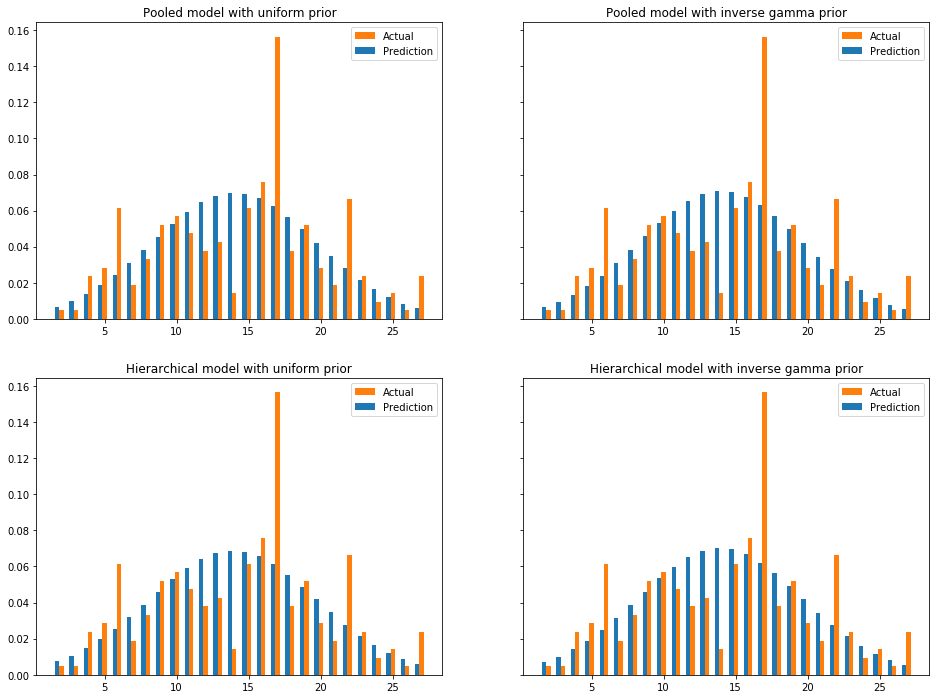

In [76]:
compare_predictive_vs_actual(fits=[pool_uni_fit, pool_inv_fit, hier_uni_fit, hier_inv_fit], labels=[
	'Pooled model with uniform prior',
	'Pooled model with inverse gamma prior',
	'Hierarchical model with uniform prior',
	'Hierarchical model with inverse gamma prior'],
     ypred_accessors= ['ypred', 'ypred', 'ypred_new', 'ypred_new'], new_data=last)

### Observation

Posterior predictive distribution are almost identical among all models. This can be guessed already in session 3, where the data can be seen to by highly consistent throughout different tournaments. 

Errors are considerable between prediction and actual distribution. Albeit the posterior of the estimand seems to follow a normal distribution, the amount of data in only one new tournament is too small to construct a normal distribution, hence the difference between prediction and actual values.

## 9 Conclusion


**Problems**
* Data model cannot be used for direct inference of a single match

**Potential improvements**
* Given the outcome of this report, binomial can be a good fit as well
* Data model can be improved so that the estimand is a joint distribution of some parameters (e.g. absolute ranking + win degree)
* Data model can be modified to fit with multinomial model
 
**Discussion**

From the badminton domain perspective, the result is satisfiable:
* There is a visible correlation between ranking spread and win degree
* Probability of extreme outcome (towards 1 or 28) are low, and not expected in the tournament
 
From the statistical inference perspective, the result is also satisfiable
* Given the domain knowledge, one would expect the distribution of the estimand to be a normal distribution
* Given the found posteriors, we can see the result is highly data-driven

___

# Source code

In [24]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import pystan
import stan_utility
import psis
import plot_tools
from scipy import stats

# For hiding warnings that do not effect the functionality of the code
import warnings
warnings.filterwarnings('ignore')

In [70]:
# Data is provided as files, 1 file contains all matches result of a tournament
# We will use data from all tournaments to fit model
# Except for the last one which will be used to evaluate prediction accuracy
data = []
filenames = os.listdir(r'./data/')
for idx, filename in enumerate(filenames):
    col = np.loadtxt(f'data//{filename}').tolist()
    if (idx == (len(filenames) - 1)):
        last = col
    else:
        data.append(col[0:67])

np_data = np.array(data)

def show_first_rows_of_data():
    df = pd.DataFrame(np_data.T)
    df.columns=['Tournament '+str(i+1) for i in range(np_data.shape[0])]
    df = df.rename({i: 'Match '+str(i+1) for i in range(np_data.shape[1])}, axis='index')
    return df.head()

def show_summary_of_data():
    df = pd.DataFrame(np_data.T)
    df.columns=['Tournament '+str(i+1) for i in range(np_data.shape[0])]
    return df.describe()

# print number of observations (matches) and number of predictors (tournaments)

def print_model(file_path):
    with open(file_path) as file:
        print(file.read())

pooled_data = np_data.flatten()
pooled_data_model = dict(N=len(pooled_data), y=pooled_data, alpha=1, beta=1)

pooled_inv_g_data_model = dict(N=len(pooled_data), y=pooled_data)

hierarchical_data_model = dict(N = np_data.shape[1], J= np_data.shape[0],y = np_data.T, alpha=1, beta=1)

'''
adapt_delta: 0...1
    Effects to divergences, hence to the accuracy of the posterior. 
    The smaller the value is the more strict the Stan model is in accepting sampels.
    The bigger the value is the easier the Stan model accepts samples. 
'''
def compute_model(file_path, data, chains=4, iter=2000, adapt_delta=0.9):
    # Compile model for both separated and pooled
    model = stan_utility.compile_model(file_path) 

    # Fit model: adapt_delta is used for divergences
    fit = model.sampling(data=data, seed=194838,chains=chains, iter=iter, control=dict(adapt_delta=adapt_delta))

    # get summary of the fit, use pandas data frame for layout
    summary = fit.summary()
    df = pd.DataFrame(summary['summary'], index=summary['summary_rownames'], columns=summary['summary_colnames'])
    
    return df, fit

def print_compact_fit(fit_df, number_of_rows_head=5, number_of_rows_tail=5):
    df = fit_df.head(number_of_rows_head)
    df = df.append([{'mean':'...','se_mean':'...','sd':'...','2.5%':'...','25%':'...',
                   '50%':'...','75%':'...','97.5%':'...','n_eff':'...','Rhat':'...'}])
    df = df.rename({0: '...'}, axis='index')
    df = df.append(fit_df.tail(number_of_rows_tail))
    return df

def print_compact_fit_checking(fit, df):
    #Check the maximum value of the Rhat
    print("Maximum value of the Rhat: ")
    print(df.describe()['Rhat'][7])
    print("")
    
    # Check divergences
    print("Divergences:")
    stan_utility.check_div(fit)
    print("")

def compare_new_predictive_against_actual_distribution(new_preds, actual, new_pred_labels, actual_label):
    fig, axes = plot_tools.hist_multi_sharex(
        [new_preds[i] for i in range(len(new_preds))]+[actual],
        rowlabels= [ new_pred_labels[i] for i in range(len(new_pred_labels))]+[actual_label],
        n_bins=30,x_lines=np.mean(actual),figsize=(7, 10) )
    plt.show()
    

def compare_psis_loo(fits, model_labels):
    psis_loos, p_effs, k_max, k_min, k_mean = [], [], [], [], []
    for fit in fits:
        psis_loo, p_eff, ks = extract_psis_loo(fit)
        psis_loos.append(psis_loo)
        p_effs.append(p_eff)
        k_max.append(np.max(ks))
        k_min.append(np.min(ks))
        k_mean.append(np.mean(ks))
    
    df = pd.DataFrame({
        'Models': model_labels,
        'Psisloo': psis_loos,
        'P_eff': p_effs,
        'Max k value': k_max,
        'Min k value': k_min,
        'Mean k value': k_mean
    })
    
    return df.round(2)

def get_p_eff(log_lik, lppd_loocv):    
    likelihoods = np.asarray([np.exp(log_likelihood.flatten()) for log_likelihood in log_lik])
    num_sim, num_obs = likelihoods.shape
    lppd = 0
    for obs in range(num_obs):
        lppd += np.log(np.sum(likelihoods[:, obs]) / num_sim)
    
    p_eff = lppd - lppd_loocv
    return p_eff
    
def extract_psis_loo(samples, plot_title=''):
    log_lik_matrix = np.asarray([single_sample.flatten() for single_sample in samples['log_lik']])
    loo, loos, ks = psis.psisloo(log_lik_matrix)

    # Calculate p_eff
    p_eff = get_p_eff(log_lik_matrix, loo)

    return loo, p_eff, ks

def compare_predictive_vs_actual(fits, labels, ypred_accessors, new_data):
    bar_width = 0.3
    fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True,figsize=(16,12), subplot_kw=dict(aspect='auto'))
    plots = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]
    
    # Group new_data 
    # e.g. [1,2,3,2,2] => [1: 0.2, 2: 0.6, 3: 0.2]
    aggregated = dict()
    for i in new_data:
        if i in aggregated:
            aggregated[i] += 1
        else:
            aggregated[i] = 1

    # Dist of new_data
    x = np.array(list(aggregated.keys()))
    y = np.array(list(aggregated.values())) / len(test_data)
    
    for i in range(0, len(fits)):
        fit = fits[i]
        label = labels[i]
        ypred_accessor = ypred_accessors[i]
        ypred = fit.extract(permuted=True)[ypred_accessor]
        
        # Dist of ypred for new_data values
        y2_dist = stats.norm(np.mean(ypred), np.std(ypred))
        y2 = y2_dist.pdf(x)
        
        partial_plt = plots[i]
        partial_plt.bar(x,y,width=bar_width,label="Actual", color="C1")
        partial_plt.bar(x-bar_width,y2,width=bar_width,label="Prediction", color="C0")
        partial_plt.set_title(label)
        partial_plt.legend()
    
    plt.show()


___

# Attachment 1: Fit of pooled model with uniform prior

In [4]:
print(pool_uni_fit)

NameError: name 'pool_uni_fit' is not defined

___

# Attachment 2: Fit of pooled model with inverse gamma prior

In [ ]:
print(pool_inv_fit)

___

# Attachment 3: Fit of hierarchical model with uniform prior

In [ ]:
print(hier_uni_fit)

___

# Attachment 4: Fit of hierarchical model with inverse gamma prior

In [ ]:
print(hier_inv_fit)

___

REMOVE EVERYTHING STARTING HERE!

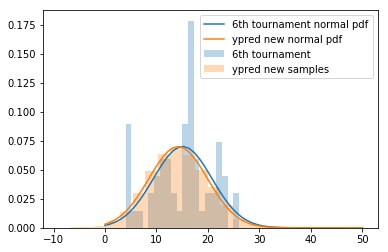

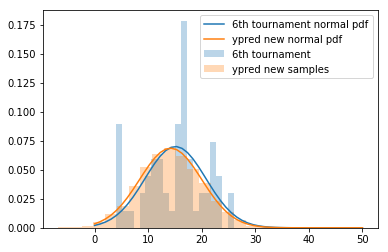

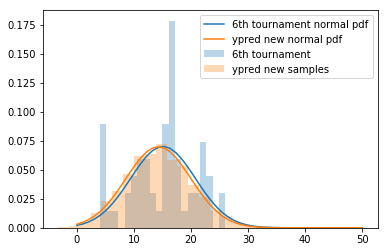

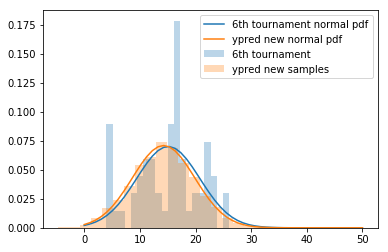

In [51]:
#Note that for hierarchical models, the new predictive tournament is computed from common hyperparatemers
# ypreds = [
#     pool_uni_fit.extract(permuted=True)['ypred'],     #Pooled unifrom new predictive tournament
#     pool_inv_fit.extract(permuted=True)['ypred'],     #Pooled inverse gamma new predictive tournament
#     hier_uni_fit.extract(permuted=True)['ypred_new'], #Hierarchical unifrom new predictive tournament 
#     hier_inv_fit.extract(permuted=True)['ypred_new']  #Hierarchical inverse gamma new predictive tournament
# ]
# ypreds_labels = ['Pooled uniform', 'Pooled inverse gamma', "Hierarchical uniform", "Hierarchical inverse gamma"]

#print("The predictive distributions of the models and the actual distribution")
#compare_new_predictive_against_actual_distribution(ypreds,pooled_data,ypreds_labels,'Original data set')
from scipy import stats

ypred = hier_inv_fit.extract(permuted=True)['ypred_new']
test_data = last
x = np.linspace(0,50, 50)
y = stats.norm(np.mean(test_data), np.std(test_data)).pdf(x)
plt.hist(test_data, bins=20, normed=True, alpha=0.3, label="6th tournament", color="C0")
plt.plot(x,y, label="6th tournament normal pdf", color="C0")

y2 = stats.norm(np.mean(ypred), np.std(ypred)).pdf(x)
plt.hist(ypred, bins=20, normed=True, alpha=0.3, label="ypred new samples", color="C1")
plt.plot(x,y2,label="ypred new normal pdf", color="C1")
plt.legend()
plt.show()

ypred = hier_uni_fit.extract(permuted=True)['ypred_new']
test_data = last
x = np.linspace(0,50, 50)
y = stats.norm(np.mean(test_data), np.std(test_data)).pdf(x)
plt.hist(test_data, bins=20, normed=True, alpha=0.3, label="6th tournament", color="C0")
plt.plot(x,y, label="6th tournament normal pdf", color="C0")

y2 = stats.norm(np.mean(ypred), np.std(ypred)).pdf(x)
plt.hist(ypred, bins=20, normed=True, alpha=0.3, label="ypred new samples", color="C1")
plt.plot(x,y2,label="ypred new normal pdf", color="C1")
plt.legend()
plt.show()

ypred = pool_uni_fit.extract(permuted=True)['ypred']
test_data = last
x = np.linspace(0,50, 50)
y = stats.norm(np.mean(test_data), np.std(test_data)).pdf(x)
plt.hist(test_data, bins=20, normed=True, alpha=0.3, label="6th tournament", color="C0")
plt.plot(x,y, label="6th tournament normal pdf", color="C0")

y2 = stats.norm(np.mean(ypred), np.std(ypred)).pdf(x)
plt.hist(ypred, bins=20, normed=True, alpha=0.3, label="ypred new samples", color="C1")
plt.plot(x,y2,label="ypred new normal pdf", color="C1")
plt.legend()
plt.show()

ypred = pool_inv_fit.extract(permuted=True)['ypred']
test_data = last
x = np.linspace(0,50, 50)
y = stats.norm(np.mean(test_data), np.std(test_data)).pdf(x)
plt.hist(test_data, bins=20, normed=True, alpha=0.3, label="6th tournament", color="C0")
plt.plot(x,y, label="6th tournament normal pdf", color="C0")

y2 = stats.norm(np.mean(ypred), np.std(ypred)).pdf(x)
plt.hist(ypred, bins=20, normed=True, alpha=0.3, label="ypred new samples", color="C1")
plt.plot(x,y2,label="ypred new normal pdf", color="C1")
plt.legend()
plt.show()
# fig, axes = plt.subplots(1, 1, sharey=True,figsize=(16,4), subplot_kw=dict(aspect='auto'))
# fig.suptitle('Predictive distributions of the blablabla')

# axes.scatter([i for i in range(len(pooled_data))],pooled_data,marker="o", color="C1", alpha=0.5)
# axes.scatter([i for i in range(len(pooled_data))],pooled_data,marker="x", color="C0")
# plt.show()


# the predictive distribution of all the models look similar, 
# therefore the prediction of the new tournament looks similar as the one which was left out

In [ ]:
raw_data = np.loadtxt('data.txt')

# Aggregate raw result
aggregated_result = {}
for i in range(-11,12):
    aggregated_result[str(i)] = []

for (spread, result) in raw_data:
    key = str(int(spread))
    aggregated_result[key].append(result)
        
# Turn to 23 x 3 matrix, where columns are win, lose, number of games, and rows are the possible spread
data_matrix = []
for key, value in aggregated_result.items():
    total = len(value)
    win = len([i for i in value if i > 0])
    data_matrix.append([win, total - win, total])

print(data_matrix)
print(len(data_matrix))
print(aggregated_result)

In [ ]:
# Read data and convert it to matrix with dimensions [6x23]
raw_data = pd.read_csv('data.txt', sep=" ", header=None)
raw_data.columns = ['spread','win']
raw_data = raw_data.groupby(['spread', 'win']).size().reset_index(name='counts')


data_json = {i: [0 for j in range(-11,12)] for i in range(1,7)}
for index, row in raw_data.iterrows():
    data_json[row['win']][11+row['spread']] = row['counts']

data = pd.DataFrame(data=data_json)
def getRowText():
    j=-11
    c = {}
    for i in range(0,23):
        c[i] = j
        j += 1
    return c

data.rename(index=getRowText(), inplace=True)
data = data.T
print(data)

In [ ]:
def convertData(dataset):
    win = dataset[0:3].sum(axis=0).values 
    lose = dataset[3:7].sum(axis=0).values 
    return np.array([win,lose])

tt = convertData(data)


In [ ]:
# Data #######
raw_data = pd.read_csv('kristel.txt', sep=" ", header=None)
print(raw_data)


highest_frequency = max([8,8,7,7,6,6,5,5,4,3,2])+2
#data = dict(N=11, n=[highest_frequency for i in range(0,11)], 
#            y=np.array(list(reversed([8,8,7,7,6,6,5,5,4,3,2]))), x=[1,2,3,4,5,6,7,8,9,10,11])
data = dict(r=23, c=3, y=data_matrix)

def fit_model(model_code='stan_code\\binom-logistic-regression.stan'):
    model = stan_utility.compile_model(model_code)
    fit = model.sampling(data=data, seed=194838, chains=4, iter=4000)
    samples = fit.extract(permuted=True)
    print(fit)
    stan_utility.check_treedepth(fit)
    stan_utility.check_energy(fit)
    stan_utility.check_div(fit)
    return samples

In [ ]:
# Models
with open('stan_code\\binom-logistic-regression.stan') as file:
    print(file.read())

In [ ]:
# logistic_samples = fit_model('stan_code\\binom-logistic-regression.stan')

In [ ]:
logistic_samples = fit_model('stan_code\\multinomial.stan')

In [ ]:
####### Multinomial #######






In [ ]:
def show_model_fit(x, y, mu):    
    figsize = plt.rcParams['figure.figsize'].copy()
    figsize[0] *= 2  # width
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # scatterplot and lines
    color_scatter = 'C0'  # 'C0' for default color #0
    color_line = 'C1'     # 'C1' for default color #1
    # lighten color_line
    color_shade = (1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line))))
    # plot
    ax.fill_between(
        x,
        np.percentile(mu, 5, axis=0),
        np.percentile(mu, 95, axis=0),
        color=color_shade
    )
    ax.plot(
        x,
        np.percentile(mu, 50, axis=0),
        color=color_line,
        linewidth=1
    )
    ax.scatter(x, y, 5, color=color_scatter)
    ax.set_xlabel('Spread')
    ax.set_ylabel('Normalized frequency')
    ax.set_title('Wins per spread')
    plt.show()
    
show_model_fit(data["x"],data["y"]/np.array([highest_frequency]), logistic_samples['p'])

In [ ]:
"""from scipy import stats
for i in range(0,11):
    mu = np.mean(logistic_samples['y_rep'][:,i])
    std = np.std(logistic_samples['y_rep'][:,i])
    x = np.linspace(0,11,100)
    plt.plot(x, stats.norm(mu,std).pdf(x))
    #plt.hist(logistic_samples['y_rep'][:,i], alpha=0.2, density=True)
plt.show()
"""


plt.scatter(logistic_samples["alpha"],logistic_samples["beta"])
plt.show();
plt.hist(logistic_samples["alpha"], bins=50)
plt.hist(logistic_samples["beta"], bins=50)
plt.show();

"""plt.scatter(data["x"],data["y"]/np.array([highest_frequency]))
def calc(a,b,xp):
    return np.exp(a + b*xp)/(1 + np.exp(a + b*xp))"""

FOR PSISLOO IF NEEDED

In [ ]:
# LPPD: Posterior predictive distribution summarized by the simulation draws of theta^s
def compute_LPPD(samples):
    lppd_all = 0
    samples = np.array(samples)
    N = samples.shape[1]
    S = samples.shape[0]
    for i in range(0,N):
        lppd_all += np.log(np.sum(np.exp(samples[:,i]))/S)
    return lppd_all

# LPPD LOO-CV: Bayesian loo-cv (leave-one-out cross-validation) estimate of out-of-sample predictive fit
def compute_PSIS_LOO_values_and_plot_k(samples, model_text='Separate model'):
    # Compute bayesian loo-cv using psisloo function
    lppd_loo_cv, lppd_loos_cv, lppd_loo_k = psis.psisloo(samples)

    #Estimate of the effective number of parameters
    p_loo_cv = compute_LPPD(samples) - lppd_loo_cv
    
    # Plot k-values
    plt.scatter(range(0,samples.shape[1]),lppd_loo_k,label=model_text, alpha=0.7)
    
    return {'loo_cv':lppd_loo_cv, 'loos_cv':lppd_loos_cv, 'loo_k':lppd_loo_k, 'p_loo_cv': p_loo_cv}

#Reshape matrix of [SxNxJ] to [Sx(N*J)]
def reshape_array(samples):
    samples_all = np.array(samples)
    S = samples_all.shape[0]
    N = samples_all.shape[1]
    J = samples_all.shape[2]
    samples_reshaped = []
    for s in range(0,S):
        temp = []
        for n in range(0,N):
            for j in range(0,J):
                temp.append(samples_all[s,n,j])
        samples_reshaped.append(temp)
    return np.array(samples_reshaped)


#samples = sfit.extract(permuted=True)
#compute_PSIS_LOO_values_and_plot_k(reshape_array(samples["log_lik"]))

# check the number of large (> 0.5) Pareto k estimates
#np.sum(ks1 > 0.5)